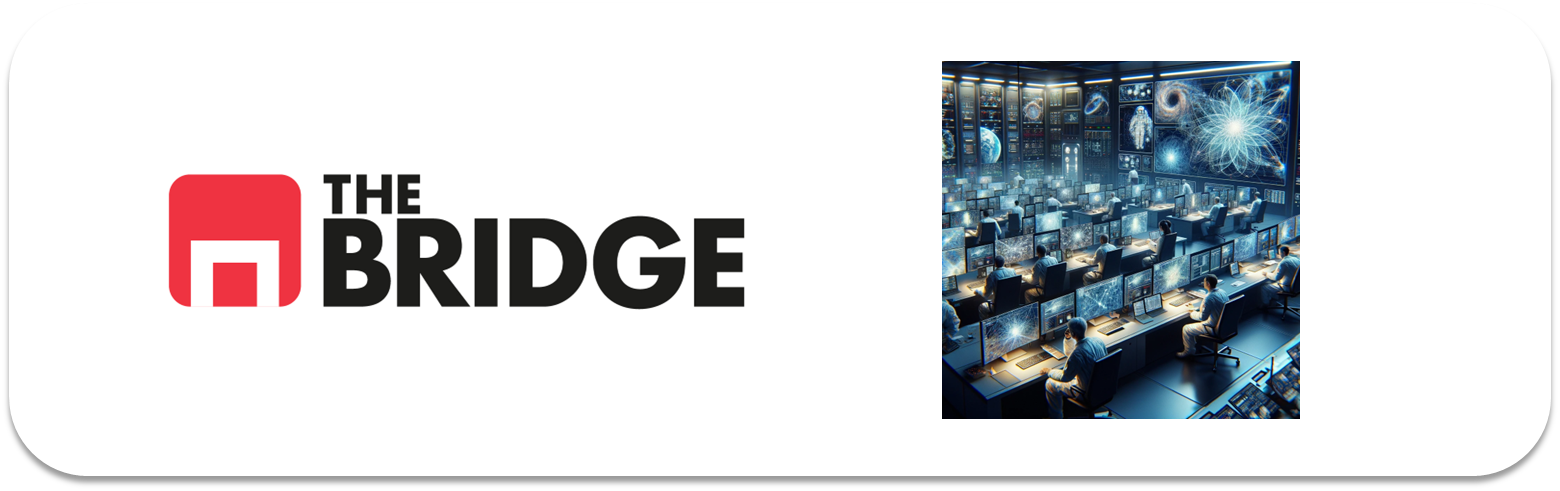

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import warnings
# filter warnings
warnings.filterwarnings('ignore')

import keras
import cv2 # OpenCV para cargar y redimensionar imágenes
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [3]:
ROOT_PATH = './data/'
TRAIN_PATHS = [ROOT_PATH + "github_train_0/", ROOT_PATH + "github_train_1/", ROOT_PATH + "github_train_2/", ROOT_PATH + "github_train_3/"]
TEST_PATH = ROOT_PATH + "github_test/"

In [4]:
# 1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes
# (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución
# para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad.
# NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

# Inicializar las listas para las características (X) y etiquetas (y)
X_train = []
y_train = []
X_test = []
y_test = []

# Función para extraer la clase de la imagen (en función de su nombre)
def get_class_from_filename(filename):
    if 'dog' in filename:
        return 1  # Etiqueta para perro
    elif 'cat' in filename:
        return 0  # Etiqueta para gato
    else:
        return -1  # Si no es ni perro ni gato, no asignamos etiqueta (por seguridad)

# Leer las imágenes de entrenamiento
for train_path in TRAIN_PATHS:
    for filename in os.listdir(train_path):
        # Cargar imagen
        img_path = os.path.join(train_path, filename)
        img = cv2.imread(img_path)
        
        # Redimensionar la imagen a 32x32
        img_resized = cv2.resize(img, (32, 32))
        
        # Convertir la imagen a un array
        img_array = img_to_array(img_resized)
        
        # Añadir la imagen al conjunto de entrenamiento (X) y su clase al conjunto de etiquetas (y)
        X_train.append(img_array)
        y_train.append(get_class_from_filename(filename))

# Leer las imágenes de prueba
for filename in os.listdir(TEST_PATH):
    # Cargar imagen
    img_path = os.path.join(TEST_PATH, filename)
    img = cv2.imread(img_path)
    
    # Redimensionar la imagen a 32x32
    img_resized = cv2.resize(img, (32, 32))
    
    # Convertir la imagen a un array
    img_array = img_to_array(img_resized)
    
    # Añadir la imagen al conjunto de prueba (X) y su clase al conjunto de etiquetas (y)
    X_test.append(img_array)
    y_test.append(get_class_from_filename(filename))

# Convertir las listas a arrays de numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

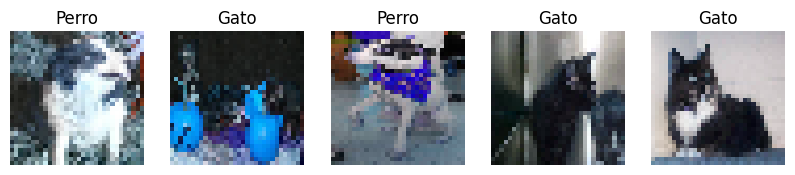

In [5]:
# 2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling.
# Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

# Visualización de algunas imágenes de entrenamiento
def plot_images(X, y, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        idx = random.randint(0, X.shape[0]-1)  # Escoger una imagen aleatoria
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[idx].astype('uint8'))
        plt.title(class_names[y[idx]])  # Mostrar la clase correspondiente
        plt.axis('off')
    plt.show()

# Visualizar imágenes de entrenamiento
class_names = ['Gato', 'Perro']
plot_images(X_train, y_train, class_names)


##### MiniEDA

In [6]:
# Estadísticas del dataset
unique_classes, counts = np.unique(y_train, return_counts=True)
print(f"Distribución de clases en el conjunto de entrenamiento: {dict(zip(class_names, counts))}")

# Confirmar las dimensiones de los conjuntos creados
print(f"Dimensiones X_train: {X_train.shape}")
print(f"Dimensiones y_train: {y_train.shape}")
print(f"Dimensiones X_test: {X_test.shape}")
print(f"Dimensiones y_test: {y_test.shape}")


Distribución de clases en el conjunto de entrenamiento: {'Gato': np.int64(2000), 'Perro': np.int64(2000)}
Dimensiones X_train: (4000, 32, 32, 3)
Dimensiones y_train: (4000,)
Dimensiones X_test: (1000, 32, 32, 3)
Dimensiones y_test: (1000,)


##### Construcción del modelo Convolucional

In [7]:
# Crear el modelo CNN
model = models.Sequential()

# Primer bloque convolucional
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))  # Capa convolucional
model.add(layers.MaxPooling2D((2, 2)))  # Capa de max-pooling

# Segundo bloque convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Capa convolucional
model.add(layers.MaxPooling2D((2, 2)))  # Capa de max-pooling

# Aplanar la salida para las capas densas
model.add(layers.Flatten())

# Capa densa para clasificación
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Salida para 2 clases (perro y gato)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,561 (1.20 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5320 - loss: 0.6917 - val_accuracy: 0.6300 - val_loss: 0.6462
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6411 - loss: 0.6333 - val_accuracy: 0.6360 - val_loss: 0.6396
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6889 - loss: 0.5934 - val_accuracy: 0.7040 - val_loss: 0.5876
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7366 - loss: 0.5375 - val_accuracy: 0.6890 - val_loss: 0.5913
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7372 - loss: 0.5095 - val_accuracy: 0.7230 - val_loss: 0.5599
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7812 - loss: 0.4525 - val_accuracy: 0.7440 - val_loss: 0.5409
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7988 - loss: 0.4111 - val_accuracy: 0.7350 - val_loss: 0.5835
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8254 - loss: 0.3778 - val_acc

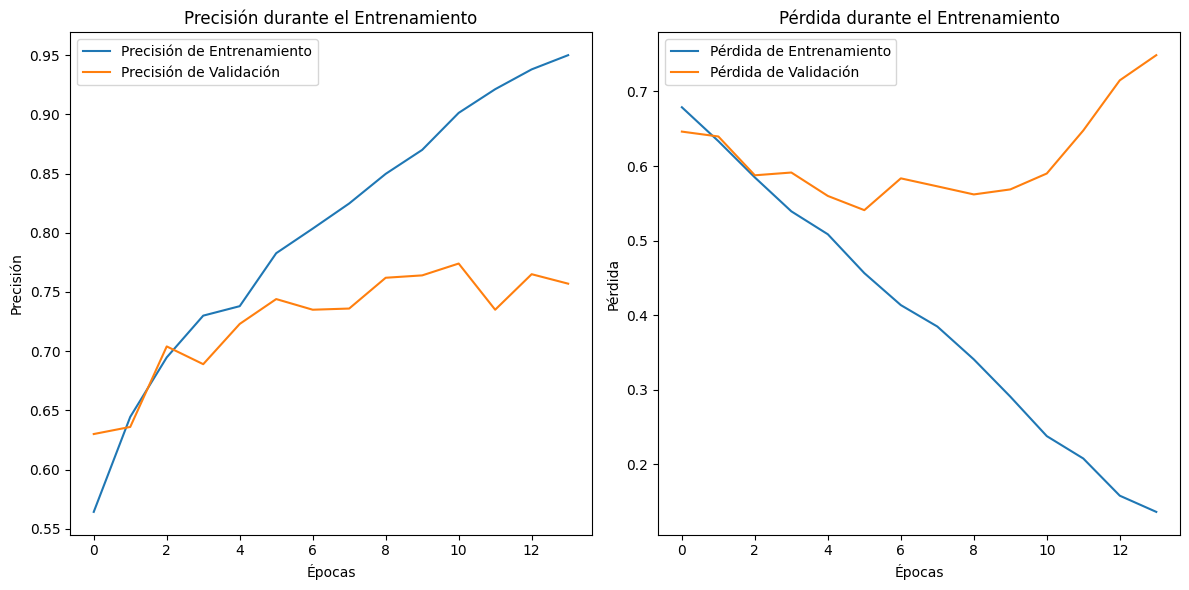

In [8]:
# 3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

# Normalizar los datos de entrada (a valores entre 0 y 1)
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Crear el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True, 
                               verbose=1)

# Entrenar el modelo con EarlyStopping
history = model.fit(X_train_norm, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_norm, y_test),
                    callbacks=[early_stopping])

# Mostrar el historial de entrenamiento
plt.figure(figsize=(12, 6))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


Pérdida en test: 0.540883481502533
Precisión en test: 0.7440000176429749
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Reporte de Clasificación:

              precision    recall  f1-score   support

        Gato       0.74      0.76      0.75       500
       Perro       0.75      0.73      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



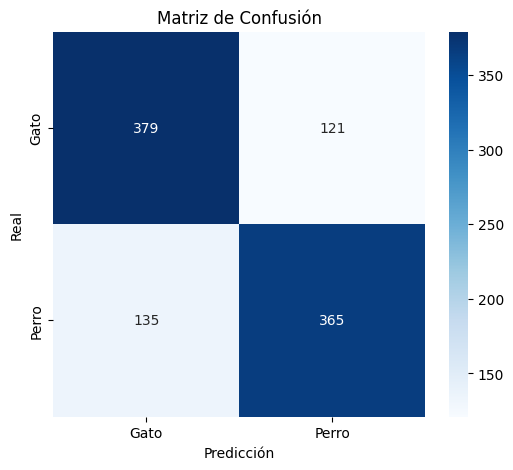

In [9]:
# 4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test, verbose=0)
print(f'Pérdida en test: {test_loss}')
print(f'Precisión en test: {test_accuracy}')

# Predecir las etiquetas en el conjunto de prueba
y_pred = (model.predict(X_test_norm) > 0.5).astype("int32")  # Umbral de 0.5 para clasificación binaria

# Reporte de clasificación
print("\nReporte de Clasificación:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


In [10]:
# 5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase
# que tengan el mayor nivel de confianza de que pertenencían a la clase errónea.
# Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perros más alta.

# Predicciones del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_norm)  # Predicción en probabilidad (0 a 1)
y_pred = (y_pred_prob[:, 0] > 0.5).astype(int) # Si la probabilidad de la clase 0 (gato) es mayor a 0.5, es gato (0), sino perro (1)

# Suponiendo:
# y_pred_prob: array (n, 1) de probabilidades de que la imagen sea "perro"
# y_pred: array (n,) obtenido con: y_pred = (y_pred_prob > 0.5).astype(int)
# y_test: array (n,) con las etiquetas reales (0 para gato, 1 para perro)

# Aseguramos que sean vectores unidimensionales:
y_pred = y_pred_prob[:, 0] > 0.5  # Esto da un array booleano
y_pred = y_pred.astype(int)
y_test = y_test.reshape(-1)

# Identificar índices de imágenes mal clasificadas
incorrect_classifications = np.where(y_pred != y_test)[0]
print("Total de imágenes mal clasificadas:", len(incorrect_classifications))

# Separar en dos grupos:
# 1. Perros (y_test==1) mal clasificados como gatos (y_pred==0)
dogs_as_cats = [idx for idx in incorrect_classifications if y_test[idx] == 1 and y_pred[idx] == 0]
# 2. Gatos (y_test==0) mal clasificados como perros (y_pred==1)
cats_as_dogs = [idx for idx in incorrect_classifications if y_test[idx] == 0 and y_pred[idx] == 1]

print("Perros clasificados como gatos:", len(dogs_as_cats))
print("Gatos clasificados como perros:", len(cats_as_dogs))

# Ordenar cada grupo basándose en la "confianza" de la clase errónea:
# Para perros mal clasificados como gatos, el valor de y_pred_prob es menor a 0.5,
# pero queremos los que tienen el valor más alto (más cercanos a 0.5).
dogs_as_cats_sorted = sorted(dogs_as_cats, key=lambda idx: y_pred_prob[idx, 0], reverse=True)

# Para gatos mal clasificados como perros, la probabilidad de ser perro es > 0.5,
# así que la "confianza de ser gato" es 1 - y_pred_prob. Queremos los más altos, es decir, los que tienen y_pred_prob más cercanos a 0.5.
cats_as_dogs_sorted = sorted(cats_as_dogs, key=lambda idx: y_pred_prob[idx, 0])

# Seleccionar el 10% de cada grupo (aseguramos que al menos se seleccione 1)
num_dogs_as_cats = max(1, int(0.1 * len(dogs_as_cats_sorted)))
num_cats_as_dogs = max(1, int(0.1 * len(cats_as_dogs_sorted)))

selected_dogs_as_cats = dogs_as_cats_sorted[:num_dogs_as_cats]
selected_cats_as_dogs = cats_as_dogs_sorted[:num_cats_as_dogs]

# Unir ambos conjuntos:
imagenes_seleccionadas = np.concatenate([np.array(selected_dogs_as_cats), np.array(selected_cats_as_dogs)])
print("Total de imágenes seleccionadas:", len(imagenes_seleccionadas))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Total de imágenes mal clasificadas: 256
Perros clasificados como gatos: 135
Gatos clasificados como perros: 121
Total de imágenes seleccionadas: 25


Total de imágenes en X_test: 1000
Total de imágenes mal clasificadas (incorrect_classifications): 256
Total de imágenes seleccionadas (imagenes_seleccionadas): 25
Índices de algunas imágenes seleccionadas: [700 929 934 578 507 687 557 907 763 727]


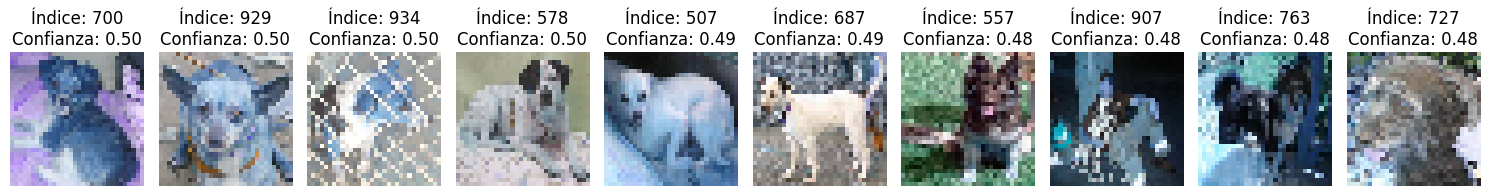

In [11]:
# Verificamos que X_test tenga imágenes
print(f"Total de imágenes en X_test: {len(X_test)}")
print(f"Total de imágenes mal clasificadas (incorrect_classifications): {len(incorrect_classifications)}")
print(f"Total de imágenes seleccionadas (imagenes_seleccionadas): {len(imagenes_seleccionadas)}")
print("Índices de algunas imágenes seleccionadas:", imagenes_seleccionadas[:10])

# Visualización de las primeras 10 imágenes seleccionadas
if len(imagenes_seleccionadas) > 0:
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(imagenes_seleccionadas[:10]):
        plt.subplot(1, 10, i+1)
        # Asegúrate de que X_test[idx] tenga el formato adecuado (por ejemplo, uint8)
        plt.imshow(X_test[idx].astype('uint8'))
        # Mostrar el índice y la probabilidad (suponiendo que y_pred_prob tiene forma [n, 1])
        plt.title(f"Índice: {idx}\nConfianza: {y_pred_prob[idx, 0]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No se han seleccionado imágenes para visualizar.")
